# 필요한 모듈 import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 필요한 함수 정의

### 포지셔널 인코딩 레이어

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(position=tf.range(
            position, dtype=tf.float32)[:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 스케일드 닷 프로덕트 어텐션 함수

In [3]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 멀티 헤드 어텐션

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
              (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 마스킹

In [5]:
## 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

## 룩어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 인코더

In [6]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기

In [7]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i),
                                )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

In [8]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i),
                            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

### 디코더 층을 쌓아 디코더 만들기

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

## 데이터 불러오기


In [10]:
csv_path = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData.csv'

chatbot_data = pd.read_csv(csv_path)
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## 데이터 전처리하기

In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

처음에 한글이랑 숫자를 추가 안해줘서 확인 안하고 넘어갔다가 데이터가 전부 없어져서 한참 찾았다.....   
가-힣, 0-9



In [12]:
# Q, A 분류

inputs, outputs = [], []

for q, a in zip(chatbot_data['Q'], chatbot_data['A']):
    inputs.append(preprocess_sentence(q))
    outputs.append(preprocess_sentence(a))   

처음에 여기서 엄청 많은 시간을 소모했다   
q,a를 나눠야 하는데 계속 에러가 나서 찾고 찾다가 zip 함수를 발견하고 사용하니 무리없이 해결했다   
후....   

In [13]:
## 데이터 샘플 수 확인
print("전체 샘플 수\n{}\n{}".format(len(inputs), len(outputs)))

전체 샘플 수
11823
11823


In [14]:
# 전처리 샘플 확인
for i in range(11):
    print("전처리 후 {}번째 질문 샘플 : {}".format(i+1, inputs[i]))
    print("전처리 후 {}번째 답변 샘플 : {}".format(i+1, outputs[i]))
    print()

전처리 후 1번째 질문 샘플 : 12시 땡 !
전처리 후 1번째 답변 샘플 : 하루가 또 가네요 .

전처리 후 2번째 질문 샘플 : 1지망 학교 떨어졌어
전처리 후 2번째 답변 샘플 : 위로해 드립니다 .

전처리 후 3번째 질문 샘플 : 3박4일 놀러가고 싶다
전처리 후 3번째 답변 샘플 : 여행은 언제나 좋죠 .

전처리 후 4번째 질문 샘플 : 3박4일 정도 놀러가고 싶다
전처리 후 4번째 답변 샘플 : 여행은 언제나 좋죠 .

전처리 후 5번째 질문 샘플 : ppl 심하네
전처리 후 5번째 답변 샘플 : 눈살이 찌푸려지죠 .

전처리 후 6번째 질문 샘플 : sd카드 망가졌어
전처리 후 6번째 답변 샘플 : 다시 새로 사는 게 마음 편해요 .

전처리 후 7번째 질문 샘플 : sd카드 안돼
전처리 후 7번째 답변 샘플 : 다시 새로 사는 게 마음 편해요 .

전처리 후 8번째 질문 샘플 : sns 맞팔 왜 안하지
전처리 후 8번째 답변 샘플 : 잘 모르고 있을 수도 있어요 .

전처리 후 9번째 질문 샘플 : sns 시간낭비인 거 아는데 매일 하는 중
전처리 후 9번째 답변 샘플 : 시간을 정하고 해보세요 .

전처리 후 10번째 질문 샘플 : sns 시간낭비인데 자꾸 보게됨
전처리 후 10번째 답변 샘플 : 시간을 정하고 해보세요 .

전처리 후 11번째 질문 샘플 : sns보면 나만 빼고 다 행복해보여
전처리 후 11번째 답변 샘플 : 자랑하는 자리니까요 .



## Subword Text Encoder 사용하기

### 단어장 만들기


In [15]:
# Q, A에 대한 Vocabulary 생성

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)

In [16]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [17]:
## 시작, 종료 토큰에 부여된 정수 출력

print("START_TOKEN 번호 : {}\nEND_TOKEN 번호 : {}".format([tokenizer.vocab_size], [tokenizer.vocab_size + 1]))

START_TOKEN 번호 : [8162]
END_TOKEN 번호 : [8163]


In [18]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


### 각 단어 고유 정수로 인코딩 & 패딩

In [19]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(inputs[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(outputs[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]


In [20]:
MAX_LENGTH = 10

In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 20 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 20으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 9108
필터링 후의 답변 샘플 개수: 9108


### 교사 강요 사용하기

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 정의 및 학습

In [24]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs) 
    
    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads,
                          dropout=dropout, )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads,
                          dropout=dropout, )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 생성

In [25]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE, num_layers=NUM_LAYERS, units=UNITS, d_model=D_MODEL, num_heads=NUM_HEADS, dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수

In [26]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 커스텀 된 학습률

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

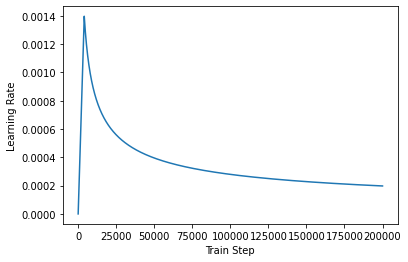

In [28]:
## 커스텀 학습률 스케줄링 계획 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [29]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [30]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
143/143 [==============================] - 10s 27ms/step - loss: 5.6130 - accuracy: 0.0954
Epoch 2/50
143/143 [==============================] - 4s 27ms/step - loss: 4.7605 - accuracy: 0.1777
Epoch 3/50
143/143 [==============================] - 4s 26ms/step - loss: 3.9382 - accuracy: 0.2150
Epoch 4/50
143/143 [==============================] - 4s 26ms/step - loss: 3.5588 - accuracy: 0.2178
Epoch 5/50
143/143 [==============================] - 4s 26ms/step - loss: 3.3643 - accuracy: 0.2257
Epoch 6/50
143/143 [==============================] - 4s 26ms/step - loss: 3.2042 - accuracy: 0.2353
Epoch 7/50
143/143 [==============================] - 4s 26ms/step - loss: 3.0465 - accuracy: 0.2453
Epoch 8/50
143/143 [==============================] - 4s 26ms/step - loss: 2.8771 - accuracy: 0.2589
Epoch 9/50
143/143 [==============================] - 4s 27ms/step - loss: 2.6912 - accuracy: 0.2764
Epoch 10/50
143/143 [==============================] - 4s 26ms/step - loss: 2.4902 - accur

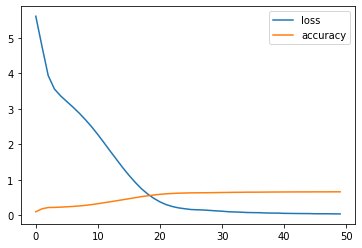

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

## 챗봇 테스트하기

In [32]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [33]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [34]:
sentence_generation('심심해')

입력 : 심심해
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [35]:
sentence_generation('밥 뭐 먹지?')

입력 : 밥 뭐 먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [36]:
sentence_generation('배고파')

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [37]:
sentence_generation('지루해')

입력 : 지루해
출력 : 마음에 따라 얼마든지 바뀔 수 있어요 .


'마음에 따라 얼마든지 바뀔 수 있어요 .'

In [38]:
sentence_generation('누구냐?')

입력 : 누구냐?
출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

In [39]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [40]:
sentence_generation('좋아해')

입력 : 좋아해
출력 : 고백하세요 .


'고백하세요 .'

In [41]:
sentence_generation('어려워')

입력 : 어려워
출력 : 제가 위로해 드릴게요 .


'제가 위로해 드릴게요 .'

In [42]:
sentence_generation('사랑이란 뭘까?')

입력 : 사랑이란 뭘까?
출력 : 사랑에는 답이 없어요 .


'사랑에는 답이 없어요 .'

In [43]:
sentence_generation('돌아왔구나 오태식이')

입력 : 돌아왔구나 오태식이
출력 : 그럴 수도 아닐 수도 있겠네요 .


'그럴 수도 아닐 수도 있겠네요 .'

In [44]:
sentence_generation('이름')

입력 : 이름
출력 : 위로봇이요 .


'위로봇이요 .'

In [45]:
sentence_generation('코로나')

입력 : 코로나
출력 : 내 꿈 꿔 !


'내 꿈 꿔 !'

In [46]:
sentence_generation('코로나19')

입력 : 코로나19
출력 : 또 다른 사랑이 찾아올 거예요 .


'또 다른 사랑이 찾아올 거예요 .'

In [51]:
sentence_generation('술')

입력 : 술
출력 : 맨날 술이야 .


'맨날 술이야 .'

In [47]:
sentence_generation('담배')

입력 : 담배
출력 : 숨기는 것보다는 낫죠 .


'숨기는 것보다는 낫죠 .'

In [48]:
sentence_generation('금연')

입력 : 금연
출력 : 자신을 이겨야해요 .


'자신을 이겨야해요 .'

In [49]:
sentence_generation('운동')

입력 : 운동
출력 : 운동을 함께 해보세요 .


'운동을 함께 해보세요 .'

In [50]:
sentence_generation('혈액순환')

입력 : 혈액순환
출력 : 그건 좀 참아보세요 .


'그건 좀 참아보세요 .'

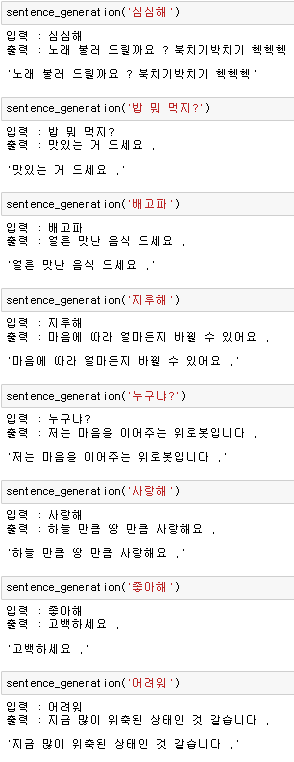

padding을 post 대신 pre로 했는데 아주 엉망진창으로 결과 값이 나왔다   
전혀 상관없는 대답을 한다.   
대표적으로
```
입력 : 지루해
답변 : 다른 생각을 숴�뇌세포에 사로 시작하는 수 있어요 .
```
캡쳐를 못해서 아쉽다 이런 식으로 전부 이상한 말들만 써져 있었다.

정확도가 계속해서 35%만 나온다

정확도를 향상 시키기 위해서 BATCH_SIZE, epoch, padding 등 다양한 파라미터를 변경해 봤지만
어떤 방식을 쓰던지 계속해서 33~38 사이의 정확도만 나온다

더 늘리기 위해서는 전처리에 조금 더 집중해야 할 것 같다.

마지막으로 MAX_LENGTH를 20에서 10으로 줄여주니 갑자기 정확도가 확 올라갔다.   
하지만 결과값을 보면 정확도가 올라간 것에 비해 드라마틱한 결과물은 나오지 않는다.  
반대로 말하면 낮은 정확도에도 괜찮은 결과값을 출력한다고 볼 수 있다.
